# DECEPTIVE REVIEW CLASSIFIER

In [140]:
!pip install --upgrade transformers
!pip install simpletransformers
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

In [141]:
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 10.7 GB  |     Proc size: 3.1 GB
GPU RAM Free: 2972MB | Used: 8469MB | Util  74% | Total     11441MB


In [142]:
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')
import gc
from scipy.special import softmax
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

In [143]:
import random
import torch
pd.options.display.max_colwidth = 200

def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

seed_all(2)

In [144]:
#importing libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import statistics
import math
import os
from sklearn.metrics import log_loss
from sklearn.metrics import *
from sklearn.model_selection import *
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import re
pd.set_option('max_colwidth', 800)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [145]:
#loading dataset
df=pd.read_csv('/content/deceptive.csv')
df.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,hyatt,positive,TripAdvisor,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,hyatt,positive,TripAdvisor,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,truthful,omni,positive,TripAdvisor,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,hyatt,positive,TripAdvisor,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [146]:
# checking the no of rows and columns of the dataset
df.shape

(1600, 5)

In [147]:
#checking the count of the deceptive column
df['deceptive'].value_counts()

truthful     800
deceptive    800
Name: deceptive, dtype: int64

In [148]:
#checking the count of the polarity column
df['polarity'].value_counts()

negative    800
positive    800
Name: polarity, dtype: int64

This is perfectly balanced dataset. Our target variable is 'deceptive'.

In [149]:
#checking the count of the hotel column
df['hotel'].value_counts()

monaco              80
hilton              80
hardrock            80
fairmont            80
homewood            80
palmer              80
omni                80
talbott             80
affinia             80
conrad              80
intercontinental    80
knickerbocker       80
swissotel           80
james               80
ambassador          80
sheraton            80
allegro             80
hyatt               80
sofitel             80
amalfi              80
Name: hotel, dtype: int64

In [150]:
# checking the count of the source column
df['source'].value_counts()

MTurk          800
TripAdvisor    400
Web            400
Name: source, dtype: int64

### DATA PREPROCESSING AND EDA

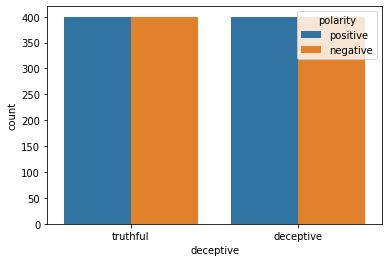

In [151]:
import seaborn as sns
sns.countplot(x=df['deceptive'],hue='polarity',data=df)

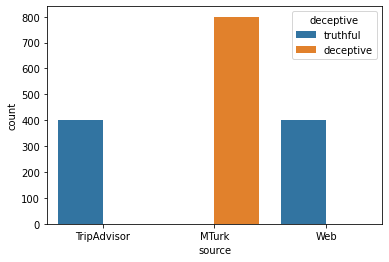

In [152]:
sns.countplot(x=df['source'],hue='deceptive',data=df)

In [153]:
df.columns

Index(['deceptive', 'hotel', 'polarity', 'source', 'text'], dtype='object')

In [154]:
# dropping unnecessary columns. 
# dropping hotel names
# dropping the source of the data
# dropping the polarity of the dataset
df.drop(['hotel', 'polarity', 'source'], axis = 1, inplace=True)
df.head()

,deceptive,text
0,truthful,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,truthful,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [155]:
z = {'truthful' : 1, 'deceptive' : 0}  # 1 for truthful reviews and 0 for deceptive reviews
df['deceptive'] = df['deceptive'].map(z)

In [156]:
df.head()

,deceptive,text
0,1,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,1,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,1,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,1,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,1,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [157]:
# Cleaning Raw tweets
def clean_text(text):
    
    #remove emails
    text = ' '.join([i for i in text.split() if '@' not in i])
    
    #remove web address
    text = re.sub('http[s]?://\S+', '', text)

    #remove brackets and parantheses (and removing the text inside the brackets and parantheses)
    text = re.sub("[\(\[].*?[\)\]]", "", text)

    #remove punctuations
    text = re.sub(r'[^\w\s]', ' ', text)
    
    #Filter to allow only alphabets and numbers
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    #remove double spaces 
    text = re.sub('\s+', ' ', text)
    
    return text

In [158]:
# applying that into function.
df["clean_text"] = df['text'].apply(lambda x: clean_text(x))
df.head(10)

,deceptive,text,clean_text
0,1,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n",We stayed for a one night getaway with family on a thursday Triple AAA rate of was a steal th floor room complete with in plasma TV bose stereo voss and evian water and gorgeous bathroom Concierge was very helpful You cannot beat this location Only flaw was breakfast was pricey and service was very very slow even though there were only two other tables in the restaurant Food was very good so it was worth the wait I would return in a heartbeat A gem in chicago
1,1,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n",Triple A rate with upgrade to view room was less than which also included breakfast vouchers Had a great view of river lake Wrigley Bldg Tribune Bldg Most major restaurants Shopping Sightseeing attractions within walking distance Large room with a very comfortable bed
2,1,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h...",This comes a little late as I m finally catching up on my reviews from the past several months A dear friend and I stayed at the Hyatt Regency in late October for one night while visiting a friend and her husband from out of town This hotel is perfect IMO Easy check in and check out Lovely clean comfortable rooms with great views of the city I know this area pretty well and it s very convenient to many downtown Chicago attractions We had dinner and went clubing with our friends around Division St We had no problems getting cabs back and forth to the Hyatt and there s even public transportation right near by but we didn t bother since we only needed cabs from and to the hotel Parking as is usual for Chicago was expensive but we were able to get our car out quickly No problems at all and...
3,1,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n",The Omni Chicago really delivers on all front

In [159]:
# dropping the uncleaned text column "text"
df = df.drop(['text'], axis=1)

In [160]:
# renaming the column
df.rename(columns = {'clean_text':'text', 'deceptive' : 'label'}, inplace = True)
df.head()

,label,text
0,1,We stayed for a one night getaway with family on a thursday Triple AAA rate of was a steal th floor room complete with in plasma TV bose stereo voss and evian water and gorgeous bathroom Concierge was very helpful You cannot beat this location Only flaw was breakfast was pricey and service was very very slow even though there were only two other tables in the restaurant Food was very good so it was worth the wait I would return in a heartbeat A gem in chicago
1,1,Triple A rate with upgrade to view room was less than which also included breakfast vouchers Had a great view of river lake Wrigley Bldg Tribune Bldg Most major restaurants Shopping Sightseeing attractions within walking distance Large room with a very comfortable bed
2,1,This comes a little late as I m finally catching up on my reviews from the past several months A dear friend and I stayed at the Hyatt Regency in late October for one night while visiting a friend and her husband from out of town This hotel is perfect IMO Easy check in and check out Lovely clean comfortable rooms with great views of the city I know this area pretty well and it s very convenient to many downtown Chicago attractions We had dinner and went clubing with our friends around Division St We had no problems getting cabs back and forth to the Hyatt and there s even public transportation right near by but we didn t bother since we only needed cabs from and to the hotel Parking as is usual for Chicago was expensive but we were able to get our car out quickly No problems at all and...
3,1,The Omni Chicago really delivers on all fronts from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue While this address in Chicago requires a high level of quality the Omni delivers Check in for myself and a whole group of people with me was under minutes the staff had plentiful recommendations for dining and events and the rooms are some of the largest you ll find at this price range in Chicago Even the standard room has a separate living area and work desk The fitness center has free weights weight machines and two rows of cardio equipment I shared the room with others and did not feel cramped in any way All in all a great property
4,1,I asked for a high floor away from the elevator and that is what I got The room was pleasantly decorated functional and very clean I didn t need a whole lot of service but when I did they were pleasant and prompt I used the fitness center which was well equipped and everything was in working order It is in a great location at one end of the Michigan Avenue shopping district


In [161]:
# shuffling the data
df = df.sample(frac=1).reset_index(drop=True)

### WORD VISUALIZATION

In [162]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [163]:
#making worldcloud
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
print(stop_words)

{'his', 'other', 'ma', "wasn't", 'for', 'can', 'whom', 'did', 'if', 'are', 'hadn', 'should', 'while', 'that', "should've", 'a', 'her', 'needn', "mustn't", 'themselves', 'too', 'in', 'm', 'below', 'against', 'my', 've', 'didn', "wouldn't", 'who', 'those', 'he', 'him', 'doing', 'any', 'each', 'only', "doesn't", 'what', 'about', 'i', 'some', 'you', 'under', 're', "hadn't", 'between', 'when', 'had', 'above', 'yours', 'again', 'd', "shouldn't", "you've", 'couldn', 'very', 'and', 'does', 'here', 'aren', 'am', 'how', 'because', 'ours', "shan't", 'she', 'just', 'our', "she's", 'through', 'their', 'the', "that'll", 'or', 'ourselves', 'this', 'them', 'has', 'into', "didn't", 'we', 'wasn', "mightn't", 'most', 'as', 'which', 'during', 'further', 'mustn', 'at', 'both', 'nor', 'on', "weren't", "don't", 'haven', 'an', 'such', "won't", 'won', 'me', 'these', 'is', 'than', 'mightn', 'shouldn', 'don', 'from', 'myself', 'have', "isn't", 'y', 'out', 'yourselves', 'do', 'off', 't', 'before', 'own', 'it', 'i

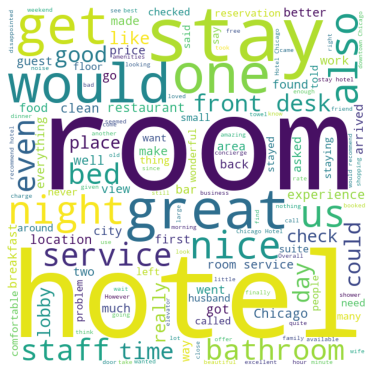

In [164]:
# visualizing the most frequent words using matplot library
comment_words = ' '
for words in df['text']: 
    comment_words = comment_words + words + ' '
    
wordcloud = WordCloud(width = 600, height = 600, 
                background_color='white' , 
                stopwords = stop_words, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

In [165]:
X = df['text'].values
y = df['label'].values

### TRAIN - TEST SPLIT

In [166]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, stratify=y)


In [167]:
train_df = pd.DataFrame(X_train)
train_df['label'] = y_train

In [168]:
train_df 

,0,label
0,THE ROOM I booked a room here and was told I d be getting a king bed When I check in they say they only have a queen bed room available I protested to no avail When I got to the room it was really only a full size bed So I went from from a king bed at home to a full size bed in a tiny broom closet of a room in Chicago For the pleasure I paid the same price as a normal king bed room The full size bed we had was also extremely uncomfortable I think it was lop sided because they never rotate the mattresses We would wake up with body aches and headaches My wife even said she lost feeling in her arms some nights Not good Also the internet in the room is hard to set up slow to use and inconsistent I generally had to restart my computer at least once to get the internet to work The internet w...,1
1,Very disappointed in our stay in Chicago Monoco We have stayed many times elsewhere primarily in washington DC and are accustomed to great customer service beverages like water or soda at the wine bar coffee and papers in the morning help with bags Not only did the Chicago monoco do none of these things the staff was not helpful either Requests were not honored and the staff did not seem happy to be there YOu got the feeling you were bothering people if you asked a question No bellman the doorman did not open the door or help with bags Even though we were traveling with a child I had to request a fish when they did not bring it Really baffling as we love the Monoco in Washington,1
2,I recently stayed at the Amalfi Hotel Chicago in Chicago Illinois I must say that staying at this hotel is like staying at a high end hotel for celebrities There are spa packages room service and the hotel is decorated extremely beautifully I would recommend this hotel to anyone that is looking to be treated like a star They take reservations and also have a great restaurant right inside of the building Whatever you need they will accommodate you This is heaven on earth I would recommend anyone to stay at this hotel even if its for one day its worth it,0
3,This was our third trip to Chicago this year every time we stay at a different downtown hotel Swissotel was definitely our favourite When we come back in July to see the play Wicked for the second time we will be again at Swissotel No more need to try other hotels The location is good because it is between the financial district and the Magnificent Mile The room was spotless and quiet the view amazing and those elevators were so fast Comfortable beds friendly service not as many noisy sirens We even watched the Navy Pier fireworks from our bed This was the best anniversary ever We would recommend Swissotel to everyone,1
4,We arrived at the Omni on nd September for a day stay I took ill when I left the plane after travelling from Manchester so I saw more of the room than I anticipated I couldn t go out for days The room was spacious and clean The bed was extremely comfortable The bathroom was large and very clean What more could you ask We had coffee and juice left outside our door every morning at the time we requested I managed to go to the th floor to see the sun terrace Having a sun terrace in a city hotel is a great idea but the terrace was a bit grim A few sunbeds on a concrete floor There was also noise from an air conditioning unit It could do with a bit of cheering up What I saw of Chicago was very pleasing it has something for everyone Would I go back to the Omni yes I would,1
...,...,...
1515,I had heard good things regarding the plush accomidations at The Talbott Hotel in Chicago I thought it would be a special treat to take my year old daughter to spend a weekend with mom shopping and enjoying a bit of Chicago s exciting night life I found The Talbott Hotel s website and decided The American Girl Package they offer was what I was looking for The price sounded reasonable so I booked a room The two of us were so very excited to spend some time together We arrived at the hotel to check in

In [169]:
eval_df = pd.DataFrame(X_test)
eval_df['label'] = y_test

In [170]:
train_df.shape, eval_df.shape

((1520, 2), (80, 2))

### MODEL BUILDING - XLNET 

In [172]:
# We will import ClassificationModel - as we need to solve binary text classification
from simpletransformers.classification import ClassificationModel
import pandas as pd
import logging
import sklearn


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# They are lot of arguments to play with
'''
args = {
   'output_dir': 'outputs/',
   'cache_dir': 'cache/',
   'fp16': True,
   'fp16_opt_level': 'O1',
   'max_seq_length': 256,
   'train_batch_size': 8,
   'eval_batch_size': 8,
   'gradient_accumulation_steps': 1,
   'num_train_epochs': 3,
   'weight_decay': 0,
   'learning_rate': 4e-5,
   'adam_epsilon': 1e-8,
   'warmup_ratio': 0.06,
   'warmup_steps': 0,
   'max_grad_norm': 1.0,
   'logging_steps': 50,
   'evaluate_during_training': False,
   'save_steps': 2000,
   'eval_all_checkpoints': True,
   'use_tensorboard': True,
   'overwrite_output_dir': True,
   'reprocess_input_data': False,
}

'''

# Create a ClassificationModel
model = ClassificationModel('xlnet', 'xlnet-base-cased', args={'num_train_epochs':4, 'train_batch_size':32, 'overwrite_output_dir': True, 'max_seq_length':128}) # You can set class weights by using the optional weight argument

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=sklearn.metrics.accuracy_score)


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/1520 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_xlnet_128_2_2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/48 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/48 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/48 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/48 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of xlnet model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/80 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_2_2


Running Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.753778361444409, 'tp': 33, 'tn': 37, 'fp': 3, 'fn': 7, 'auroc': 0.965, 'auprc': 0.9665992966165741, 'acc': 0.875, 'eval_loss': 0.43805326223373414}


In [173]:
result

{'acc': 0.875,
 'auprc': 0.9665992966165741,
 'auroc': 0.965,
 'eval_loss': 0.43805326223373414,
 'fn': 7,
 'fp': 3,
 'mcc': 0.753778361444409,
 'tn': 37,
 'tp': 33}

Conclusion : XLNET model gives us 88% accuracy

### MODEL EVALUATION

In [174]:
text = "Excellent hotel in the heart of Chicago. The room we stayed in had a great view of Lake Michigan. We went in July for a vacation and everything is easily accesible from the hotel. Most major attractions are in around the Loop area. We also got a great deal on the price. I would recommend this hotel to anyone visiting Chicago - its in the right spot for both business and pleasure."
prediction = model.predict(text)[0]
preds = np.argmax(prediction)
if preds == 0:
  print('truthful review')
else:
  print('deceptive review')

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/382 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

deceptive review


In [175]:
text = "The Swissotel is totally understaffed and lacking any charm or atmosphere. It was clean, comfortable and had great views but if you wanted to check-in, use the concierge, check-out, or report a problem to the front desk, forget about it. I booked this place through Priceline.COM so I can't complain too much as I didn't pay a lot for the room but I have stayed at 4 star hotels in the past as well as another Swissotel. It left a lot to be desired. The minibar fridge in my room didn't work so forget about a cold beer. Also, the internet/movie/guest services console didn't work so I had to go to the business office to access the internet. When it was time to checkout the console still wasn't working. It's better than the Holiday Inn but way below expectations for a 4 star hotel"
prediction = model.predict(text)[0]
preds = np.argmax(prediction)
if preds == 0:
  print('truthful review')
else:
  print('deceptive review')

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

truthful review


In [176]:
text = "value for a suite as well as the free breakfast - get a quick bite, then head out for the day to do normal tourist stuff. Well, our stay here lasted 1 night and we quickly, and thankfully, switched to a different hotel for our last 4 nights. The room was dirty. When we opened the sofabed, the sheets were filthy and there was a mess of dirt and crumbs that fell out. Ridiculous considering this is a suite hotel where the sofabeds are likely used, and theoretically cleaned, a lot. Extra blankets were also dirty and bathrooms weren't much better. Temperature control in the room was imprecise - minor inconvenience but without clean blankets on our only night, it made for a cold stay. If you like to eat for free (they have free breakfasts and dinner on certain nights) and don't care to eat the great food Chicago has to offer, I guess some may find this place tolerable. But we found the buffet no better than average and felt like we were at a Golden Corral. The only thing this hotel really has going for it is location but there are other options in this area (we switched to The James and had a great experience). I couldn't be paid to stay here again. I'm shocked by the high overall rating given our experience."
prediction = model.predict(text)[0]
preds = np.argmax(prediction)
if preds == 0:
  print('truthful review')
else:
  print('deceptive review')

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1222 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

truthful review


In [177]:
text = "We stayed in the Millennium Knickerbocker Hotel Chicago in a standard guest room. The rooms had just been renovated, but the changes did not make much of a difference. The room was so small, it felt like we were sleeping below deck on a boat. The decor was drab and there was nothing special about the room. We were excited about the bathrobe and slippers that came with the room, but we assumed there would be a bathrobe and a pair of slippers for each of us; there was only one bathrobe and one pair of slippers. We called the front desk to ask for a second set and were treated like we were trying to scam the hotel and refused to send them. It would not have mattered if they sent a second set; the bathrobe was so scratchy it gave me a rash and there were stains on the slippers. As hotel guests, we expected to be treated with respect and enjoy the stay we paid for. We were severely disappointed."
prediction = model.predict(text)[0]
preds = np.argmax(prediction)
if preds == 0:
  print('truthful review')
else:
  print('deceptive review')

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

deceptive review
